In [ ]:
!unzip /content/drive/MyDrive/train_dataset_RUTUBE.zip

Archive:  /content/drive/MyDrive/train_dataset_RUTUBE.zip
  inflating: player_starts_train.parquet  
  inflating: requirements.txt        
  inflating: sample_submission.csv   
  inflating: small_player_starts_train.csv  
  inflating: videos.parquet          
  inflating: Описание_данных.xlsx  
  inflating: baseline.ipynb          
  inflating: emotions.csv            
  inflating: fish_to_beer.jpg        


In [ ]:
import pandas as pd
import gc
# gc.collect()
import seaborn as sns


# Загрузим данные по видео и взаимодействиям и сделаем джойн

In [ ]:
interactions = pd.read_parquet('player_starts_train.parquet')
video_info = pd.read_parquet('videos.parquet')

In [ ]:
video_info['category_title'].unique()

array(['Технологии и интернет', 'Образование', 'Авто-мото', 'Детям',
       'Бизнес и предпринимательство', 'Кулинария', 'Разное', 'Животные',
       'Лайфстайл', 'Охота и рыбалка', 'Музыка', 'Искусство',
       'Телепередачи', 'Эзотерика', 'Хобби', 'Юмор', 'Люди и блоги',
       'Техника и оборудование', 'Спорт', 'Развлечения', 'Видеоигры',
       'Строительство и ремонт', 'Сериалы', 'Красота', 'Путешествия',
       'Природа', 'Мультфильмы', 'Фильмы', 'Здоровье', 'Психология',
       'Сад и огород', 'Наука', 'Обзоры и распаковки товаров', 'Интервью',
       'Дизайн', 'Лайфхаки', 'Аудиокниги', 'Недвижимость', 'Аудио',
       'Аниме', 'Блоги', 'ПМЭФ', 'Конкурс Матч ТВ и Rutube', 'Спорт/Игры',
       'Музыка/Клипы', 'ВЭФ'], dtype=object)

In [ ]:
merged_interaction = interactions.merge(video_info,on='item_id', how='inner')

приведем duration к секундам

In [ ]:
merged_interaction['duration'] = merged_interaction['duration']/1000

Посмотрим на минимальные и максимальные значения длительности и смотрения

In [ ]:
merged_interaction['watch_time'].min()

-1

In [ ]:
merged_interaction['watch_time'].max()

78259

In [ ]:
merged_interaction['duration'].min() #лайв стримы

0.0

In [ ]:
merged_interaction['duration'].max() # футбольный матч

2147483.647

In [ ]:
'''
*Долгий просмотр определяется так: для видео меньше 5 минут
долгим считается просмотр видео с watch_time более 30 секунд,
для видео более 5 минут долгим считаем просмотр с watch_time
более 25% длительности видео
попробуем фичу длительный просмотр
если duration=0 - лайв хз, что делать
если (0,300] - то 30 сек ок
если (300, +inf), то 25% durarion
'''
def check_duration(x):
    if x == 0:
        return False # что делать с лайвом
    else:
        if x <= 300:
            return 30
        else:
            return 0.25*x

#варианты весов
#1 отнормированный
merged_interaction['weight_1'] = merged_interaction['watch_time']/ merged_interaction['duration']

#2 долгий просмотр
merged_interaction['new_duration'] = merged_interaction['duration'].apply(lambda x: check_duration(x))
merged_interaction['weight_2'] = (merged_interaction['new_duration'] <= merged_interaction['watch_time']).astype(int)

#3


In [ ]:
merged_interaction.user_id.nunique()

1313891

убедимся, что это реально лайв стримы

In [ ]:
merged_interaction[merged_interaction['duration'] == merged_interaction['duration'].min()].drop_duplicates(subset = 'item_id')

,date,user_id,item_id,watch_time,is_autorized,video_title,author_title,tv_title,season,video_description,category_title,publicated,duration,channel_sub,tv_sub,ctr.CTR_10days_21_07,ctr.CTR_10days_01_08,ctr.CTR_10days_10_08,ctr.CTR_10days_21_08
264906,2023-08-21 12:51:04+03:00,user_26890443,video_255770,271,0,Прямой эфир ТВ-3,Промо ТВ-3,ТВ-3 Лайв,0,"Смотри лучшие сериалы, фильмы, приключенческие...",Телепередачи,2023-07-03 11:56:13+03:00,0.0,1939,0,0.00,NaN,NaN,NaN
322686,2023-08-21 19:58:14+03:00,user_23961592,video_2136440,1,0,Прямой эфир Рифей-ТВ,Рифей-ТВ,None,0,«Рифей-ТВ» - круглосуточный пермский телеканал...,Телепередачи,2021-05-19 16:05:50+03:00,0.0,281,0,0.00,NaN,0.0,0.0
387927,2023-08-21 05:48:25+03:00,user_26477833,video_2052690,-1,0,Прямой эфир ТНТ,ГПМ РТВ,ТНТ live,0,Для фанатов главного развлекательного канала Т...,Телепередачи,2019-06-06 10:44:42+03:00,0.0,3064,0,NaN,0.0,NaN,0.0
411223,2023-08-21 16:31:11+03:00,user_27763560,video_505893,431,0,Прямой эфир НТВ,НТВ,None,0,"Прямой эфир НТВ. Новости, общественно-политиче...",Телепередачи,2023-04-30 13:54:22+03:00,0.0,207061,0,NaN,0.0,0.0,0.0
423941,2023-08-21 19:07:50+03:00,user_16104911,video_1979002,534,0,Первый канал. Прямой эфир,Первый канал,None,0,None,Телепередачи,2022-05-19 15:11:57+03:00,0.0,45848,0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424205,2023-08-21 18:55:27+03:00,user_7474943,video_311158,562,0,Dead Island 2 (4) Побочки и предохранители - З...,Diezel Game,None,0,Все интересные ссылки в описании канала! Обяза...,Видеоигры,2023-04-26 18:59:19+03:00,0.0,503,0,0.00,0.0,0.0,0.0
2425210,2023-08-21 11:52:39+03:00,user_23685620,video_153791,11,1,"ELSKI | Рок, Ария, Цой, Алиса, Киш, Пикник| 849",Elski,None,0,Донат: * https://www.donationalerts.com/r/elsk...,Музыка,2023-04-21 22:12:51+03:00,0.0,191,0,NaN,NaN,NaN,0.0
2427001,2023-08-21 05:06:13+03:00,user_9504189,video_1713200,60,0,ДОМ-2 Lite 4164 день Дневной эфир (04.10.2015),Дом-2,Дом-2. Lite,48,None,Телепередачи,2016-02-18 09:44:36+03:00,0.0,152974,33420,0.25,0.0,0.5,0.0
2435748,2023-08-21 21:11:51+03:00,user_1810247,video_1713053,0,0,Кубок Анатолия Рахлина по дзюдо 04.06.2023 Тат...,Федерация дзюдо Санкт-Петербурга,None,0,Международные соревнования по Дзюдо Кубок Анат...,Спорт,2023-05-27 19:21:48+03:00,0.0,50,0,0.00,NaN,NaN,0.0


In [ ]:
merged_interaction[merged_interaction['duration'] == merged_interaction['duration'].min()].video_title.value_counts()[:10]

Соловьёв LIVE | Круглосуточный канал    16106
Прямой эфир Звезда                      11685
Прямой эфир ТНТ                         11266
Прямой эфир Пятница                      8267
Первый канал. Прямой эфир                7344
Прямой эфир НТВ                          7314
Прямой эфир ТВ-3                         7192
Прямой эфир Ю-ТВ                         7189
Прямой эфир Солнце                       4107
Прямой эфир ТНТ4                         3801
Name: video_title, dtype: int64

In [ ]:
merged_interaction[merged_interaction['duration'] == merged_interaction['duration'].min()]

,date,user_id,item_id,watch_time,is_autorized,video_title,author_title,tv_title,season,video_description,category_title,publicated,duration,channel_sub,tv_sub,ctr.CTR_10days_21_07,ctr.CTR_10days_01_08,ctr.CTR_10days_10_08,ctr.CTR_10days_21_08
264906,2023-08-21 12:51:04+03:00,user_26890443,video_255770,271,0,Прямой эфир ТВ-3,Промо ТВ-3,ТВ-3 Лайв,0,"Смотри лучшие сериалы, фильмы, приключенческие...",Телепередачи,2023-07-03 11:56:13+03:00,0.0,1939,0,0.00,NaN,NaN,NaN
264907,2023-08-21 12:00:31+03:00,user_19999222,video_255770,11,0,Прямой эфир ТВ-3,Промо ТВ-3,ТВ-3 Лайв,0,"Смотри лучшие сериалы, фильмы, приключенческие...",Телепередачи,2023-07-03 11:56:13+03:00,0.0,1939,0,0.00,NaN,NaN,NaN
264908,2023-08-21 00:34:17+03:00,user_11333588,video_255770,1,0,Прямой эфир ТВ-3,Промо ТВ-3,ТВ-3 Лайв,0,"Смотри лучшие сериалы, фильмы, приключенческие...",Телепередачи,2023-07-03 11:56:13+03:00,0.0,1939,0,0.00,NaN,NaN,NaN
264909,2023-08-21 22:39:07+03:00,user_5549441,video_255770,96,0,Прямой эфир ТВ-3,Промо ТВ-3,ТВ-3 Лайв,0,"Смотри лучшие сериалы, фильмы, приключенческие...",Телепередачи,2023-07-03 11:56:13+03:00,0.0,1939,0,0.00,NaN,NaN,NaN
264910,2023-08-21 15:35:47+03:00,user_18816654,video_255770,1,0,Прямой эфир ТВ-3,Промо ТВ-3,ТВ-3 Лайв,0,"Смотри лучшие сериалы, фильмы, приключенческие...",Телепередачи,2023-07-03 11:56:13+03:00,0.0,1939,0,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424205,2023-08-21 18:55:27+03:00,user_7474943,video_311158,562,0,Dead Island 2 (4) Побочки и предохранители - З...,Diezel Game,None,0,Все интересные ссылки в описании канала! Обяза...,Видеоигры,2023-04-26 18:59:19+03:00,0.0,503,0,0.00,0.0,0.0,0.0
2425210,2023-08-21 11:52:39+03:00,user_23685620,video_153791,11,1,"ELSKI | Рок, Ария, Цой, Алиса, Киш, Пикник| 849",Elski,None,0,Донат: * https://www.donationalerts.com/r/elsk...,Музыка,2023-04-21 22:12:51+03:00,0.0,191,0,NaN,NaN,NaN,0.0
2427001,2023-08-21 05:06:13+03:00,user_9504189,video_1713200,60,0,ДОМ-2 Lite 4164 день Дневной эфир (04.10.2015),Дом-2,Дом-2. Lite,48,None,Телепередачи,2016-02-18 09:44:36+03:00,0.0,152974,33420,0.25,0.0,0.5,0.0
2435748,2023-08-21 21:11:51+03:00,user_1810247,video_1713053,0,0,Кубок Анатолия Рахлина по дзюдо 04.06.2023 Тат...,Федерация дзюдо Санкт-Петербурга,None,0,Международные соревнования по Дзюдо Кубок Анат...,Спорт,2023-05-27 19:21:48+03:00,0.0,50,0,0.00,NaN,NaN,0.0


In [ ]:
video_info[video_info['item_id'].isin(['video_68646', 'video_283933', 'video_1508623', 'video_1610334', 'video_1761620'])]

,item_id,video_title,author_title,tv_title,season,video_description,category_title,publicated,duration,channel_sub,tv_sub,ctr.CTR_10days_21_07,ctr.CTR_10days_01_08,ctr.CTR_10days_10_08,ctr.CTR_10days_21_08
155423,video_68646,"Выжить в Дубае, 8 выпуск",Телеканал ТНТ,Выжить в Дубае,1,Премьера! «Выжить в Дубае» – новое масштабное ...,Телепередачи,2023-08-13 21:00:12+03:00,5208840,75496,0,NaN,NaN,NaN,0.411112
956478,video_283933,"Выжить в Дубае, 9 выпуск",Телеканал ТНТ,Выжить в Дубае,1,Премьера! «Выжить в Дубае» – новое масштабное ...,Телепередачи,2023-08-20 21:00:23+03:00,5616280,75496,0,NaN,NaN,NaN,0.572971
1234651,video_1761620,Соловьёв LIVE | Круглосуточный канал,Соловьёв LIVE,None,0,В прямом эфире Соловьёв LIVE – новости и размы...,Телепередачи,2022-10-14 12:06:53+03:00,0,343030,0,0.000000,NaN,NaN,NaN
1504095,video_1610334,Виктория Райдос: «Можно ли изменить судьбу»,Вокруг•ТВ,None,0,40-летняя Виктория Райдос успевает сниматься в...,Лайфстайл,2023-08-17 17:20:08+03:00,144640,2146,0,NaN,NaN,NaN,0.000000
1589833,video_1508623,"Выжить в Дубае, 1 выпуск",Телеканал ТНТ,Выжить в Дубае,1,Премьера! 7 российских звезд и 7 людей со всех...,Телепередачи,2023-06-25 20:50:06+03:00,5727080,75496,0,0.026082,0.019585,0.017811,0.013777


In [ ]:
interactions.groupby('item_id').user_id.count().sort_values(ascending=False)

item_id
video_283933     146652
video_68646       23249
video_1508623     19807
video_1610334     17980
video_1761620     16106
                  ...  
video_2050225         1
video_2050227         1
video_1225808         1
video_2050266         1
video_2060204         1
Name: user_id, Length: 261288, dtype: int64

In [ ]:
interactions.groupby('user_id').item_id.count().sort_values(ascending=False)

user_id
user_23456184    3192
user_19126412    3186
user_8021211     2421
user_23184542    2328
user_10340490    2104
                 ... 
user_20009703       1
user_20009739       1
user_20009743       1
user_20009761       1
user_9999986        1
Name: item_id, Length: 1313891, dtype: int64

In [ ]:
interactions[interactions.user_id == 'user_23456184'].is_autorized.sum()

0

# Построим фичу долгий просмотр is_long

In [ ]:
merged_interaction['new_duration'] = merged_interaction['duration'].apply(lambda x: check_duration(x))

In [ ]:
merged_interaction['is_long'] = merged_interaction['new_duration'] <= merged_interaction['watch_time']

In [ ]:
merged_interaction[['duration', 'new_duration', 'watch_time', 'is_long']]

,duration,new_duration,watch_time,is_long
0,4270.647,1067.66175,22,False
1,4270.647,1067.66175,2182,True
2,4270.647,1067.66175,4262,True
3,4270.647,1067.66175,2477,True
4,4270.647,1067.66175,1,False
...,...,...,...,...
2439639,1075.067,268.76675,202,False
2439640,5732.218,1433.0545,2742,True
2439641,466.458,116.6145,461,True
2439642,110.597,30,101,True


# Корреляции

<ipython-input-26-d5935a0d44f5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_interaction.corr(), annot=True, fmt='.2f')


<Axes: >

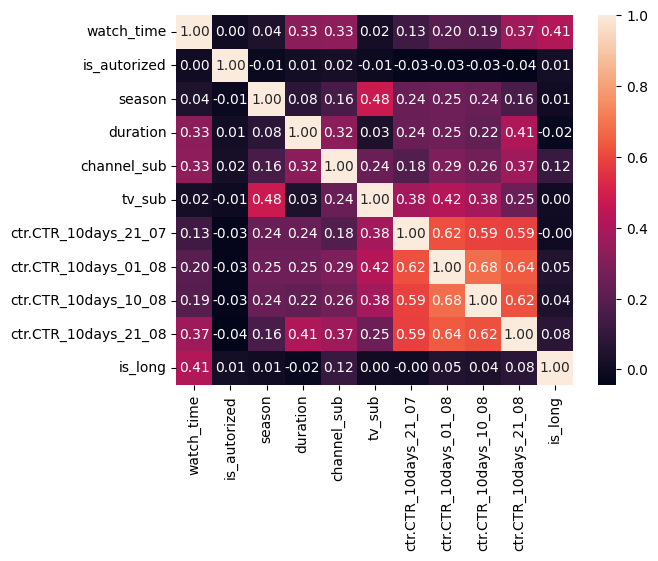

In [ ]:
sns.heatmap(merged_interaction.corr(), annot=True, fmt='.2f')

In [ ]:
# merged_interaction.loc[merged_interaction['duration'] == merged_interaction['duration'].max(),'duration'] = 0

# merged_interaction = merged_interaction[merged_interaction['duration'] > merged_interaction['duration'].min()]

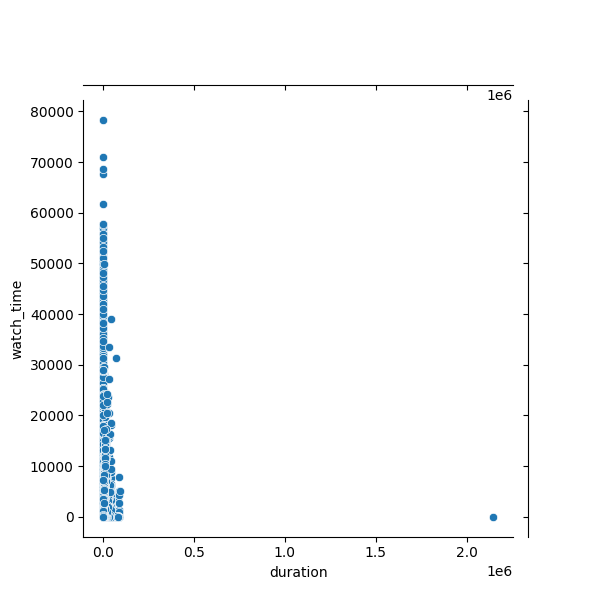

In [ ]:
sns.jointplot(data=merged_interaction, x="duration", y="watch_time")

In [ ]:
interactions['is_autorized'].value_counts()

0    3387715
1     189776
Name: is_autorized, dtype: int64

# Посмотрим на файл эмоций

In [ ]:
emotions = pd.read_csv('emotions.csv')
emotions.merge()

,date,user_id,item_id,type,emoji
0,2023-08-03 21:37:22+03:00,user_21883648,video_2247834,v_top,v_top
1,2023-08-03 21:04:54+03:00,user_24016046,video_2247834,v_top,v_top
2,2023-08-03 20:37:06+03:00,user_20748867,video_22669,v_top,v_top
3,2023-08-03 20:44:12+03:00,user_21545120,video_645471,v_top,v_top
4,2023-08-03 20:45:17+03:00,user_28987830,video_2346806,v_top,v_top
...,...,...,...,...,...
369424,2023-08-02 11:43:43+03:00,user_21597217,video_1180057,pos_emotions,Like
369425,2023-07-25 16:26:35+03:00,user_6805283,video_1180057,pos_emotions,Like
369426,2023-07-28 13:07:10+03:00,user_5419928,video_1180057,pos_emotions,Like
369427,2023-08-07 18:16:30+03:00,user_12044809,video_1180057,pos_emotions,Like


# Статистики

In [ ]:
emotions['date'].min()

'2023-07-21 00:00:23+03:00'

In [ ]:
emotions['date'].max()

'2023-08-21 23:59:53+03:00'

In [ ]:
emotions['type'].value_counts()

v_top           199907
pos_emotions    166855
neg_emotions      2667
Name: type, dtype: int64

In [ ]:
emotions['emoji'].value_counts()

v_top                 199907
Like                  105938
New_Fire               28367
Heart                  14154
Happy_glasses           7586
Laugh                   5749
Happy_Star_glasses      5061
Dislike                 1949
Sickness                 256
Gape                     172
Angry                    166
Crying                    86
Closed_mauth              38
Name: emoji, dtype: int64

# Данные по параметрам видео

In [ ]:
df = merged_interaction['video_title']+ ' ' + merged_interaction['tv_title'] + ' ' + merged_interaction['video_description']

In [ ]:
df[df.notnull()]

0          Экстрасенсы ведут расследование, 6 сезон, 16 в...
1          Экстрасенсы ведут расследование, 6 сезон, 16 в...
2          Экстрасенсы ведут расследование, 6 сезон, 16 в...
3          Экстрасенсы ведут расследование, 6 сезон, 16 в...
4          Экстрасенсы ведут расследование, 6 сезон, 16 в...
                                 ...                        
2439515    Уронили в ведро Samsung Galaxy A40 (2019) | За...
2439516    Skoda Octavia #проблема с проводкой #датчик G8...
2439575    В гостях у Леонида Якубовича. Ремонт чудес. Ид...
2439614    «Военная приемка — ЦСН ФСБ». Часть 2 Военная п...
2439624    Гузель Хасанова - Лето Имени Тебя (LIVE @ Авто...
Length: 617221, dtype: object

In [ ]:
from tqdm.notebook import tqdm
import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import re

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def washing_machine(comments): # Чистка текста от мусора
    corpus=[]
    for i in tqdm(range(len(comments))):
        comment = re.sub('\W', ' ', comments[i])
        comment = comment.lower()
        comment = comment.split()
        # stemmer = SnowballStemmer('english')
        # lemmatizer = WordNetLemmatizer()
        all_stopwords = stopwords.words('english') + stopwords.words('russian')
        # comment = [stemmer.stem(word) for word in comment if not word in set(all_stopwords)]
        comment = [word for word in comment if not word in set(all_stopwords)]

        # comment = [lemmatizer.lemmatize(word) for word in comment]
        comment = ' '.join(comment)
        corpus.append(comment)

    return corpus



In [ ]:
df = washing_machine(df[df.notnull()].reset_index(drop=True))

  0%|          | 0/617221 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
merged_interaction

,date,user_id,item_id,watch_time,is_autorized,video_title,author_title,tv_title,season,video_description,...,publicated,duration,channel_sub,tv_sub,ctr.CTR_10days_21_07,ctr.CTR_10days_01_08,ctr.CTR_10days_10_08,ctr.CTR_10days_21_08,new_duration,is_long
0,2023-08-21 15:53:30+03:00,user_7941459,video_1535803,22,0,"Экстрасенсы ведут расследование, 6 сезон, 16 в...",Экстрасенсы ведут расследование,Экстрасенсы ведут расследование,6,"Подмосковный Пушкино — почти Париж. И там, и т...",...,2022-03-29 13:14:16+03:00,4270.647,4973,0,0.243671,0.202864,0.204230,0.222222,1067.66175,False
1,2023-08-21 11:39:56+03:00,user_24377155,video_1535803,2182,0,"Экстрасенсы ведут расследование, 6 сезон, 16 в...",Экстрасенсы ведут расследование,Экстрасенсы ведут расследование,6,"Подмосковный Пушкино — почти Париж. И там, и т...",...,2022-03-29 13:14:16+03:00,4270.647,4973,0,0.243671,0.202864,0.204230,0.222222,1067.66175,True
2,2023-08-21 13:09:15+03:00,user_16795332,video_1535803,4262,0,"Экстрасенсы ведут расследование, 6 сезон, 16 в...",Экстрасенсы ведут расследование,Экстрасенсы ведут расследование,6,"Подмосковный Пушкино — почти Париж. И там, и т...",...,2022-03-29 13:14:16+03:00,4270.647,4973,0,0.243671,0.202864,0.204230,0.222222,1067.66175,True
3,2023-08-21 11:02:24+03:00,user_27937908,video_1535803,2477,0,"Экстрасенсы ведут расследование, 6 сезон, 16 в...",Экстрасенсы ведут расследование,Экстрасенсы ведут расследование,6,"Подмосковный Пушкино — почти Париж. И там, и т...",...,2022-03-29 13:14:16+03:00,4270.647,4973,0,0.243671,0.202864,0.204230,0.222222,1067.66175,True
4,2023-08-21 21:58:09+03:00,user_4800027,video_1535803,1,0,"Экстрасенсы ведут расследование, 6 сезон, 16 в...",Экстрасенсы ведут расследование,Экстрасенсы ведут расследование,6,"Подмосковный Пушкино — почти Париж. И там, и т...",...,2022-03-29 13:14:16+03:00,4270.647,4973,0,0.243671,0.202864,0.204230,0.222222,1067.66175,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439639,2023-08-21 22:24:41+03:00,user_27418475,video_2027231,202,0,АПЕЙРОФОБИЯ уровень 13-16 /Полное прохождение/...,Шайни / Shiny,None,0,Моя группа ВК - https://vk.com/shiny_ytube\nМо...,...,2022-10-18 10:11:54+03:00,1075.067,82,0,0.000000,0.333333,0.500000,0.000000,268.76675,False
2439640,2023-08-21 13:16:16+03:00,user_2095852,video_1923266,2742,0,"""Секрет на миллион"": Маша Распутина",НТВ,Секрет на миллион. Все выпуски. Все звезды. Вс...,0,None,...,2018-04-14 19:00:01+03:00,5732.218,207061,0,0.000000,0.000000,0.142857,0.000000,1433.0545,True
2439641,2023-08-21 20:38:54+03:00,user_316343,video_1729592,461,0,"Stand Up: Виктор Комаров - О самоуверенных, кр...",StandUp,STAND UP,2,None,...,2015-04-19 18:53:53+03:00,466.458,6595,0,0.000000,NaN,0.000000,0.000000,116.6145,True
2439642,2023-08-21 16:44:47+03:00,user_11895299,video_853811,101,0,? ЛЕПЕШКИ С СЫРОМ НА ВОДЕ (жареные на сковород...,Фотосессии и Моделирование ❤,None,0,📌 Рецепт с фото — https://www.iamcook.ru/showr...,...,2023-07-06 11:53:42+03:00,110.597,8,0,0.000000,0.000000,0.000000,0.000000,30,True
